In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import plotly.offline as pyo
import datetime
import matplotlib.dates as mdates

In [2]:
def parse_methane_series(filepath):
    '''
    Read in LAKE model methane file 'methane_series 1 1.dat'

    Args:
    filepath (string): full filepath to methane file

    Output:
    methane (pd.DataFrame)
    '''
    methane=pd.read_csv(filepath, delimiter=r"\s+", skiprows=35, index_col=None, header=None)
    methane.columns=['year', 'month', 'day', 'hour', 'integration_time',  'talik depth, m',
                    'lake surface methane concentration, mol/m**3',
                    'lake bottom methane concentration, mol/m**3',
                    'soil bottom methane concentration, mol/m**3',
                    'lake surface oxygen concentration, mol/m**3',
                    'lake bottom oxygen concentration, mol/m**3',
                    'total methane production due to young C decomposition, mol/(m**2*s)',
                    'total methane production due to old C decomposition, mol/(m**2*s)',
                    'methane ebullition flux averaged over the lake bottom, upwards, mol/(m**2*s)',
                    'methane ebullition flux at the surface, mol/(m**2*s)',
                    'methane plant-mediated flux at the lake bottom, mol/(m**2*s)',
                    'methane diffusion flux averaged over the lake bottom, upwards, mol/(m**2*s)',
                    'methane turbulent flux at the lake surface, upwards, mol/(m**2*s)',
                    'methane ebullition flux averaged over the lake bottom, upwards, mg/(m**2*day)',
                    'methane ebullition flux at the surface, mg/(m**2*day)',
                    'methane plant-mediated flux at the lake bottom, mg/(m**2*day)',
                    'methane diffusion flux averaged over lake bottom, upwards, mg/(m**2*day)',
                    'methane turbulent flux at the lake surface, upwards, mg/(m**2*day)',
                    'methane turbulent flux at the bottom of mixed layer normalized by  surface area, upwards, mg/(m**2*day)',
                    'methane flux from sediments in the mixed layer normalized by  surface area, upwards, mg/(m**2*day)',
                    'methane bubble flux at the bottom of the mixed layer normalized by  surface area, upwards, mg/(m**2*day)',
                    'total methane oxidation in water normalized by  surface area, mg/(m**2*day)',
                    'methane oxidation in mixed layer normalized by  surface area, mg/(m**2*day)',
                    'co2 turbulent flux at the lake surface, upwards, mol/(m**2*s)',
                    'co2 ebullition flux at the surface, mol/(m**2*s)',
                    'oxygen turbulent flux at the lake surface, upwards, mol/(m**2*s)',
                    'oxygen ebullition flux at the surface, mol/(m**2*s)',
                    'methane flux by inlets, normalized by surface area, mol/(m**2*s)',
                    'methane flux through outlet, normalized by surface area, mol/(m**2*s)',
                    'methane_ebul_sc1', 'methane_ebul_sc2', 'methane_ebul_sc3', 'methane_ebul_sc4', 'methane_ebul_sc5'] #mg/(m**2*day)
    
    methane['Date'] = pd.to_datetime({'Year': methane['year'], 'Month': methane['month'], 'Day':methane['day']})
    methane = methane[['Date','year', 'month', 'day', 'hour', 'total methane production due to young C decomposition, mol/(m**2*s)',
                       'total methane production due to old C decomposition, mol/(m**2*s)', 'methane diffusion flux averaged over the lake bottom, upwards, mol/(m**2*s)',
                       'methane ebullition flux at the surface, mol/(m**2*s)',
                       'methane ebullition flux at the surface, mg/(m**2*day)',
                       'methane turbulent flux at the lake surface, upwards, mol/(m**2*s)',
                       'methane turbulent flux at the lake surface, upwards, mg/(m**2*day)',
                       'total methane oxidation in water normalized by  surface area, mg/(m**2*day)',
                       'methane plant-mediated flux at the lake bottom, mg/(m**2*day)',
                       'co2 turbulent flux at the lake surface, upwards, mol/(m**2*s)',
                       'co2 ebullition flux at the surface, mol/(m**2*s)',
                       'oxygen turbulent flux at the lake surface, upwards, mol/(m**2*s)',
                       'oxygen ebullition flux at the surface, mol/(m**2*s)',
                       'methane_ebul_sc1', 'methane_ebul_sc2', 'methane_ebul_sc3', 'methane_ebul_sc4', 'methane_ebul_sc5']]
    
    methane.columns = ['Date', 'year', 'month', 'day', 'hour', 'methane_prod_young_mol/(m**2*s)', 'methane_prod_old_mol/(m**2*s)', 'methane_diffuse_bot_mol/(m**2*s)',
                       'methane_ebul_mol/(m**2*s)', 'methane_ebul_mg/(m**2*day)', 'methane_turb_flux_mol/(m**2*s)', 'methane_turb_flux_mg/(m**2*day)',
                      'methane_oxid_mg/(m**2*day)', 'methane_plant_med_flux_mg/(m**2*day)','co2_turb_flux_mol/(m**2*s)', 'co2_ebul_mol/(m**2*s)', 'ox_turb_flux_mol/(m**2*s)', 'ox_ebul_mol/(m**2*s)',
                      'methane_ebul_sc1', 'methane_ebul_sc2', 'methane_ebul_sc3', 'methane_ebul_sc4', 'methane_ebul_sc5']
    
    methane['run_name'] = filepath.split('/')[-2]

    return methane
    
def parse_layer_file(filepath):
    '''
    Read in LAKE model layers file 'layers 1 1.dat'

    Args:
    filepath (string): full filepath to layers file

    Output:
    layers (pd.DataFrame)
    '''
    layers=pd.read_csv(filepath, delimiter=r"\s+", skiprows=19, index_col=None, header=None)
    layers.columns=['year', 'month', 'day', 'hour', 'integration_time', 'water layer thickness, m', 
                           'W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                           'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m',
                           'ice layer thickness,   m', 'snow layer thickness,  m', 'bottom ice thickness,  m', 'reservoir volume,  m**3', 'volume deficit (accumulated),  m**3']
    layers['Date'] = pd.to_datetime({'Year': layers['year'], 'Month': layers['month'], 'Day':layers['day']})
    layers['mean_mixed_layer_thickness'] = layers[['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m']].mean(axis=1)
    layers['mean_lower_layer_thickness'] = layers[['W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m']].mean(axis=1)
    layers = layers.drop(columns = ['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                                    'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m'])
    layers['run_name'] = filepath.split('/')[-2]

    return layers

def parse_univariate_file(filepath, variable_name):
    '''
    Read in LAKE model univariate timeseries file in second format '{variable} 1 1f2.dat'. Outputs variable time series to pandas DataFrame.
    Expects first five columns are 'year', 'month', 'day', 'hour', and 'integration_time'
    --------------------------------------------------------------------------------------
    Tested for
    water temperature: filename = 'water_temp  1  1f2.dat'
    co2 conventation: filename = 'co2_water  1  1f2.dat'
    ch4 concentration: filename = 'methane_water  1  1f2.dat'
    o2 concentration: filename = 'oxygen_water  1  1f2.dat'
    doc concentration: filename = 'DOC  1  1f2.dat'
    --------------------------------------------------------------------------------------

    Args:
    filepath (string): full filepath to time series file
    vaeriable_name (string): name for time series variable column

    Output:
    layers (pd.DataFrame)
    '''
    
    file=pd.read_csv(filepath, delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    file.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', variable_name]
    file['Date'] = pd.to_datetime({'Year': file['year'], 'Month': file['month'], 'Day':file['day']})

    return file

def ppm_to_molarity(ppm, gas, T, P=1, Vh=60, Vb=160, temp_input = 'C'):
    # for headspace measurements
    # T in kelvin
    # assuming P = 1 atm
    # MW in g/mole
    
    if temp_input == 'C':
        T = T+273.15
    constants = {'ch4': {'H': 39769, 'MW': 16.04},
                 'o2': {'H': 43414, 'MW': 32},
                 'R': 1.98719}
    
    constants['ch4']['H'] = 1/(np.exp((-365.183 + 18106.7 / T + 49.7554 * np.log(T) + -0.00028503 * T) / constants['R']))
    constants['o2']['H'] = 1/(np.exp((-286.942 + 15450.6 / T + 36.5593 * np.log(T) + 0.01876620 * T) / constants['R']))
    
    Cg = (ppm*1e-6)
    pg = Cg * P #partial pressure of gas at atmospheric pressure (atm)
    CAH = 55.5 * (pg/constants[gas]['H']) * constants[gas]['MW'] + ((Vh/(Vb-Vh)) * Cg * (constants[gas]['MW']/22.4) * (273 / T)) #gas concentration in aqueous phase (g/L)

    return (CAH / constants[gas]['MW']) * 1e6 # umol gas / L water
    
def Vant_Hoff(T):
    #calculates Henry's law coefficient for CO2 at given temperature
    KHstar = 29
    kT_CO2 = 2400
    T_star = 298.15
    KH = KHstar * np.exp(kT_CO2*((1 / T) - (1 / T_star)))

    return KH
    
def ppm_to_molarity_co2(co2_ppm, T, sensor_depth=1, mean_air_pres = 100986, temp_input = 'C'):
    #for co2 sensor measurements
    p_hydrostatic = 1000 * 9.8 * sensor_depth #Pa
    co2_ppm_corr = co2_ppm * (mean_air_pres/(mean_air_pres+p_hydrostatic))

    pCO2 = co2_ppm_corr * (mean_air_pres+p_hydrostatic) * 1e-6
    
    if temp_input=='C':
        T = T+273.15
        
    KH = Vant_Hoff(T) * 101325

    MCO2 = (pCO2 / KH) #mol CO2 / L solution

    #MCO2 = MCO2 * 1000 #mol / m3
    
    return MCO2 * 1e6 #umol/L

In [3]:
layer_datafile_names={'layers': 'layers  1  1.dat'}

methane_datafile_names={'methane': 'methane_series  1  1.dat'}

univariate_datafile_names = {
                  'water_temp': 'water_temp  1  1f2.dat',
                  'soil_temp': 'soil_temp  1  1f2.dat',
                  'co2_water': 'co2_water  1  1f2.dat',
                  'ch4_water': 'methane_water  1  1f2.dat',
                  'o2_water': 'oxygen_water  1  1f2.dat',
                  'doc_water': 'DOC  1  1f2.dat',
                  'pocl_water': 'POCL  1  1f2.dat', #live POC
                  'pocd_water': 'POCD  1  1f2.dat',
                  'phosph_water': 'phosph_water  1  1f2.dat',
                  'prodox': 'prodox  1  1f2.dat',
                  'sod': 'sod  1  1f2.dat'} #dead POC

In [32]:
df_results = []
df_layers = []
df_methanes=[]
out_path = os

for dir in os.listdir():
    
    df_result = pd.DataFrame()
    
    if os.path.isdir(dir) and '.' not in dir:

        run_path = os.path.join(os.getcwd(), dir)
        
        run_path=os.path.join(run_path, 'time_series')
        df_layer = parse_layer_file(os.path.join(run_path, layer_datafile_names['layers']))
        df_methane = parse_methane_series(os.path.join(run_path, methane_datafile_names['methane']))
        
        for var_key in univariate_datafile_names:
            
            if(len(df_result)==0):
                df_result = parse_univariate_file(os.path.join(run_path, univariate_datafile_names[var_key]), var_key)
                

            else: 
                df_result = pd.merge(df_result, parse_univariate_file(os.path.join(run_path, univariate_datafile_names[var_key]), var_key))
                
        if 'unburned' in dir:
            df_result['pond'] = 'unburned'
            df_layer['pond'] = 'unburned'
            df_methane['pond'] = 'unburned'
        else:
            df_result['pond'] = 'burned'
            df_layer['pond'] = 'burned'
            df_methane['pond'] = 'burned'

        run = ''.join(dir.split('-')[2:])
        
        if run == '':
            df_result['run'] = 'control'
            df_layer['run'] = 'control'
            df_methane['run'] = 'control'
        else:
            df_result['run'] = run
            df_layer['run'] = run
            df_methane['run'] = run
        
        df_results.append(df_result)
        df_layers.append(df_layer)
        df_methanes.append(df_methane)

df_results = pd.concat(df_results)
df_results = df_results.replace(-999, np.nan)

df_layers = pd.concat(df_layers)
df_layers = df_layers.replace(-999, np.nan)

df_methanes = pd.concat(df_methanes)
df_methanes = df_methanes.replace(-999, np.nan)
df_results['run'].unique()

array(['5yr', 'nosnow5yr', 'tplus1pct5yr', 'swin20pct5yr'], dtype=object)

In [5]:
#df_results = df_results.loc[df_results['run']!='nosnow']
#df_layers = df_layers.loc[df_layers['run']!='nosnow']
#df_methanes = df_methanes.loc[df_methanes['run']!='nosnow']

#df_results = df_results.loc[df_results['Date']>='2022-01-01']
#df_layers = df_layers.loc[df_layers['Date']>='2022-01-01']
#df_methanes = df_methanes.loc[df_methanes['Date']>='2022-01-01']

In [33]:
df_results_depth_avg = df_results.groupby(by=['pond', 'run', 'Date']).mean().reset_index()

In [34]:
runs_names=df_results['run'].unique()

In [35]:
runs_names

array(['5yr', 'nosnow5yr', 'tplus1pct5yr', 'swin20pct5yr'], dtype=object)

In [36]:
time_min=pd.to_datetime('2022-07-01')
time_max=pd.to_datetime('2023-07-01')

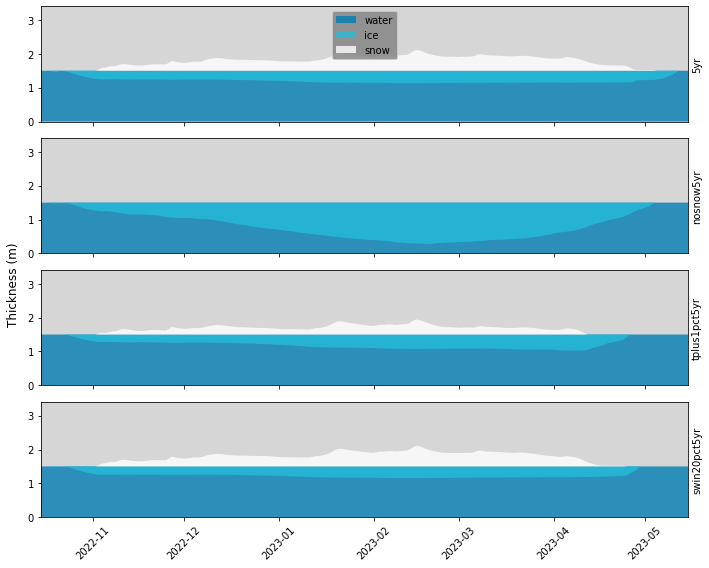

In [49]:
fig, axes = plt.subplots(len(runs_names),1, figsize=(10,2*len(runs_names)), sharex=True, sharey=True)


for i, run in enumerate(runs_names):
    
    run_data = df_layers.loc[(df_layers['run']==runs_names[i]) & (df_layers['pond']=='burned')]
    
    axes[i].fill_between(run_data['Date'], run_data['water layer thickness, m'] - run_data['mean_mixed_layer_thickness'], run_data['water layer thickness, m'],  
                    facecolor ='red', alpha = 0.8)
    axes[i].fill_between(run_data['Date'], 0, run_data['water layer thickness, m'],  
                    facecolor ='#027eb3', alpha = 0.8, label='water')
    axes[i].fill_between(run_data['Date'], run_data['water layer thickness, m']-run_data['ice layer thickness,   m'], run_data['water layer thickness, m'],  
                    facecolor ='#25bbd9', alpha = 0.8, label='ice')
    axes[i].fill_between(run_data['Date'], run_data['water layer thickness, m'], run_data['snow layer thickness,  m'] + run_data['water layer thickness, m'],  
                    facecolor ='white', alpha = 0.8, label='snow')
    axes[i].fill_between(run_data['Date'], run_data['water layer thickness, m'] - run_data['mean_mixed_layer_thickness'], run_data['water layer thickness, m'],  
                    facecolor ='red', alpha = 0.8)
    axes[i].set_facecolor('#d6d6d6')

    axes[i].set_ylabel(runs_names[i])
    axes[i].yaxis.set_label_position("right")
    axes[i].set_facecolor('#d6d6d6')

axes[0].legend(loc='upper center', facecolor = 'grey')
    

plt.ylim(0, 3.4)
plt.xticks(rotation=45)
plt.xlim(pd.to_datetime('2022-10-15'),pd.to_datetime('2023-05-15'))
fig.supylabel('Thickness (m)')
fig.tight_layout()

#plt.savefig('YKD-SA/figures/SA_layers.jpg', dpi=300)

(19174.0, 19539.0)

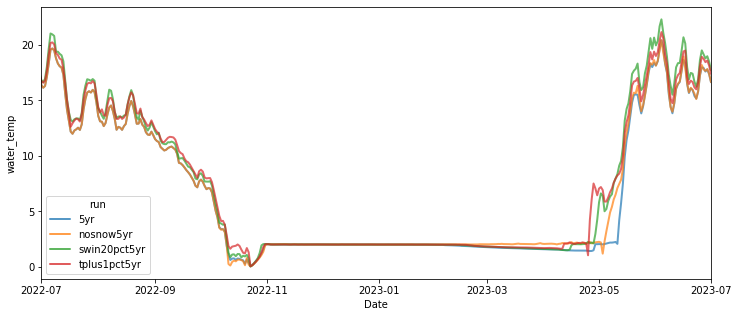

In [44]:
fig, axes = plt.subplots(figsize=(12,5), sharex=True)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='water_temp', hue='run', alpha=0.7, linewidth=2)
plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-07-01'))

(19174.0, 19539.0)

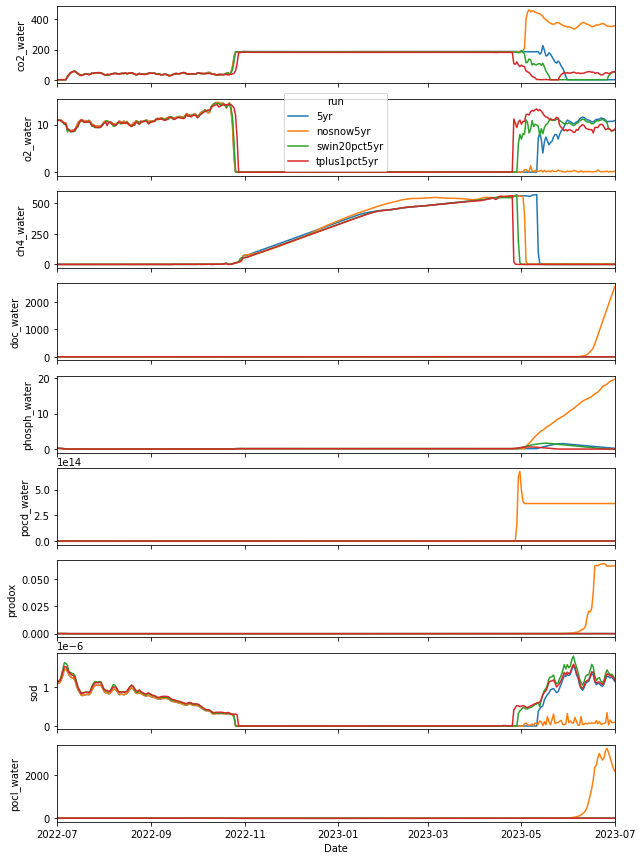

In [52]:
fig, axes = plt.subplots(9, 1,figsize=(10,15), sharex=True)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='co2_water', hue='run', ax = axes[0], legend=False)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='o2_water', hue='run', ax = axes[1])
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='ch4_water', hue='run', ax = axes[2], legend=False)
#axes[2].set_ylim(0,2)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='doc_water', hue='run', ax = axes[3], legend=False)

#axes[4].set_ylim(0,10)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='phosph_water', hue='run', ax = axes[4], legend=False)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='pocd_water', hue='run', ax = axes[5], legend=False)


sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='prodox', hue='run', ax = axes[6], legend=False)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='sod', hue='run', ax = axes[7], legend=False)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='pocl_water', hue='run', ax = axes[8], legend=False)
plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-07-01'))

(18809.0, 19539.0)

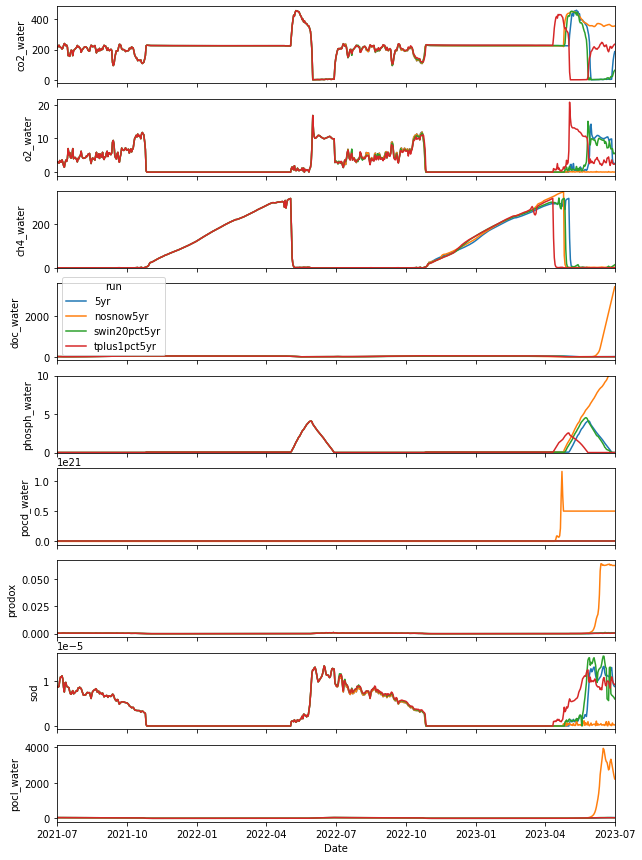

In [63]:
fig, axes = plt.subplots(9, 1,figsize=(10,15), sharex=True)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='co2_water', hue='run', ax = axes[0], legend=False)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='o2_water', hue='run', ax = axes[1], legend=False)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='ch4_water', hue='run', ax = axes[2], legend=False)
axes[2].set_ylim(0,350)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='doc_water', hue='run', ax = axes[3])

axes[4].set_ylim(0,10)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='phosph_water', hue='run', ax = axes[4], legend=False)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='pocd_water', hue='run', ax = axes[5], legend=False)


sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='prodox', hue='run', ax = axes[6], legend=False)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='sod', hue='run', ax = axes[7], legend=False)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='pocl_water', hue='run', ax = axes[8], legend=False)
plt.xlim(pd.to_datetime('2021-07-01'),pd.to_datetime('2023-07-01'))

In [72]:
pd.melt

<function pandas.core.reshape.melt.melt(frame: 'DataFrame', id_vars=None, value_vars=None, var_name=None, value_name: 'Hashable' = 'value', col_level=None, ignore_index: 'bool' = True) -> 'DataFrame'>

In [77]:
sample_comp_melt=pd.melt(df_results.loc[(df_results['Date']>='2022-07-01') & (df_results['depth']==-1)], id_vars=['Date', 'pond', 'run'])
sample_comp_melt_depth_avg = pd.melt(df_results_depth_avg.loc[(df_results_depth_avg['Date']>'2022-07-01') & (df_results_depth_avg['Date']<='2023-07-01')], id_vars=['Date', 'pond', 'run'])

In [79]:
sample_comp_melt.head(-365)

,Date,pond,run,variable,value
0,2022-07-01,unburned,5yr,year,2.022000e+03
1,2022-07-02,unburned,5yr,year,2.022000e+03
2,2022-07-03,unburned,5yr,year,2.022000e+03
3,2022-07-04,unburned,5yr,year,2.022000e+03
4,2022-07-05,unburned,5yr,year,2.022000e+03
...,...,...,...,...,...
49406,2023-06-28,unburned,nosnow5yr,sod,1.003680e-18
49407,2023-06-29,unburned,nosnow5yr,sod,4.098175e-19
49408,2023-06-30,unburned,nosnow5yr,sod,2.046435e-18
49409,2023-07-01,unburned,nosnow5yr,sod,1.231745e-18


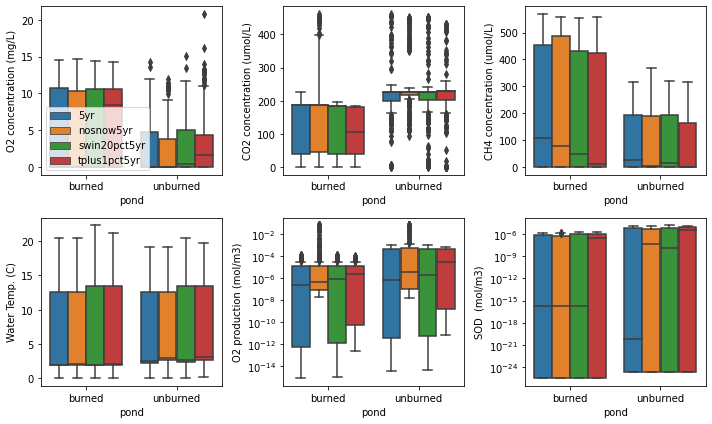

In [75]:
fig, axes=plt.subplots(2,3, figsize=(10,6))
sns.boxplot(data=sample_comp_melt_depth_avg.loc[sample_comp_melt_depth_avg['variable'] == 'o2_water'], 
            x='pond', y='value', hue='run', ax=axes[0,0])
axes[0,0].legend(title='', loc='lower left')
axes[0,0].set_ylabel('O2 concentration (mg/L)')

sns.boxplot(data=sample_comp_melt_depth_avg.loc[sample_comp_melt_depth_avg['variable'] == 'co2_water'], 
            x='pond', y='value', hue='run', ax=axes[0,1])
axes[0,1].legend().remove()
axes[0,1].set_ylabel('CO2 concentration (umol/L)')

sns.boxplot(data=sample_comp_melt_depth_avg.loc[sample_comp_melt_depth_avg['variable'] == 'ch4_water'], 
            x='pond', y='value', hue='run', ax=axes[0,2])
axes[0,2].legend().remove()
axes[0,2].set_ylabel('CH4 concentration (umol/L)')
#axes[0,2].set_ylim(0,2)

sns.boxplot(data=sample_comp_melt_depth_avg.loc[sample_comp_melt_depth_avg['variable'] == 'water_temp'], 
            x='pond', y='value', hue='run', ax=axes[1,0])
axes[1,0].legend().remove()
axes[1,0].set_ylabel('Water Temp. (C)')

sns.boxplot(data=sample_comp_melt_depth_avg.loc[sample_comp_melt_depth_avg['variable'] == 'prodox'], 
            x='pond', y='value', hue='run', ax=axes[1,1])
axes[1,1].legend().remove()
axes[1,1].set_ylabel('O2 production (mol/m3)')
axes[1,1].set_yscale('log')

sns.boxplot(data=sample_comp_melt_depth_avg.loc[sample_comp_melt_depth_avg['variable'] == 'sod'], 
            x='pond', y='value', hue='run', ax=axes[1,2])

axes[1,2].legend().remove()
axes[1,2].set_ylabel('SOD  (mol/m3)')
axes[1,2].set_yscale('log')
#axes[1,2].set_ylim(0,1e-6)

fig.tight_layout()
plt.savefig('met_exp_results.jpg', dpi=300)

In [15]:
#POC suspended in water column in ice, prevented from settling
#Biogeochemical oxygen demand consumes O2 in water in spring, low CH4 oxidation, high diffusion, low SOD
#phosphorus accumulation leads to 

In [16]:
methane_comp_melt=pd.melt(df_methanes.loc[(df_results_depth_avg['Date']>'2022-05-15') & (df_results_depth_avg['Date']<='2022-10-01')], id_vars=['Date', 'pond', 'run'])

In [17]:
df_methanes.columns

Index(['Date', 'year', 'month', 'day', 'hour',
       'methane_prod_young_mol/(m**2*s)', 'methane_prod_old_mol/(m**2*s)',
       'methane_diffuse_bot_mol/(m**2*s)', 'methane_ebul_mol/(m**2*s)',
       'methane_ebul_mg/(m**2*day)', 'methane_turb_flux_mol/(m**2*s)',
       'methane_turb_flux_mg/(m**2*day)', 'methane_oxid_mg/(m**2*day)',
       'methane_plant_med_flux_mg/(m**2*day)', 'co2_turb_flux_mol/(m**2*s)',
       'co2_ebul_mol/(m**2*s)', 'ox_turb_flux_mol/(m**2*s)',
       'ox_ebul_mol/(m**2*s)', 'methane_ebul_sc1', 'methane_ebul_sc2',
       'methane_ebul_sc3', 'methane_ebul_sc4', 'methane_ebul_sc5', 'run_name',
       'pond', 'run'],
      dtype='object')

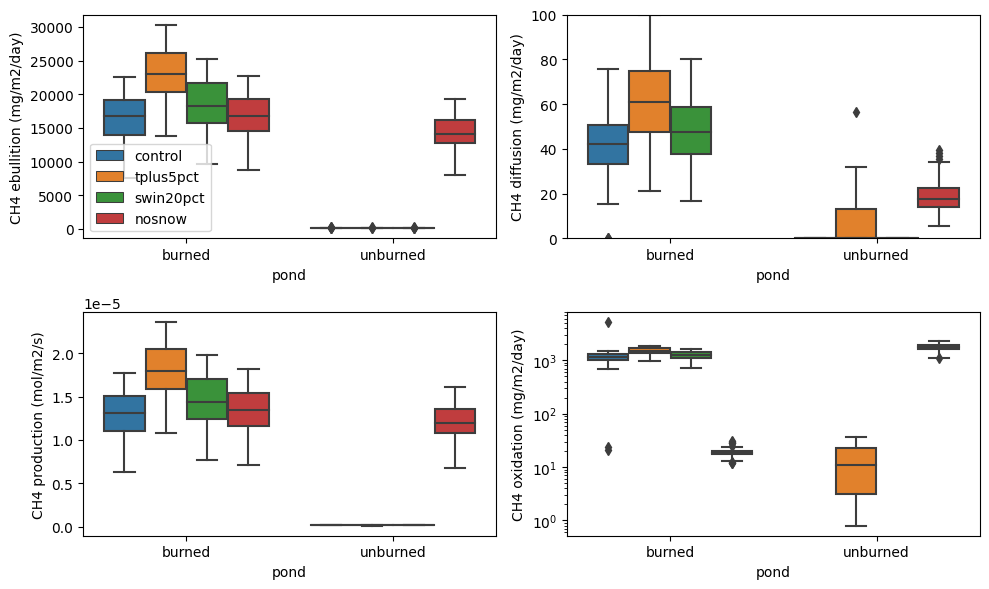

In [18]:
fig, axes=plt.subplots(2,2, figsize=(10,6))
sns.boxplot(data=methane_comp_melt.loc[methane_comp_melt['variable'] == 'methane_ebul_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0,0])
axes[0,0].legend(title='', loc='lower left')
axes[0,0].set_ylabel('CH4 ebullition (mg/m2/day)')

sns.boxplot(data=methane_comp_melt.loc[methane_comp_melt['variable'] == 'methane_turb_flux_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0,1])
axes[0,1].legend().remove()
axes[0,1].set_ylabel('CH4 diffusion (mg/m2/day)')
axes[0,1].set_ylim(0,100)

sns.boxplot(data=methane_comp_melt.loc[methane_comp_melt['variable'] == 'methane_prod_young_mol/(m**2*s)'], 
            x='pond', y='value', hue='run', ax=axes[1,0])
axes[1,0].legend().remove()
axes[1,0].set_ylabel('CH4 production (mol/m2/s)')
#axes[0,2].set_ylim(0,2)

sns.boxplot(data=methane_comp_melt.loc[methane_comp_melt['variable'] == 'methane_oxid_mg/(m**2*day)'], 
            x='pond', y=methane_comp_melt.loc[methane_comp_melt['variable'] == 'methane_oxid_mg/(m**2*day)']['value']*-1, hue='run', ax=axes[1,1])
axes[1,1].legend().remove()
axes[1,1].set_ylabel('CH4 oxidation (mg/m2/day)')
axes[1,1].set_yscale('log')

fig.tight_layout()
plt.savefig('met_exp_ch4_results.jpg', dpi=300)

<Axes: xlabel='Date', ylabel='methane_ebul_mg/(m**2*day)'>

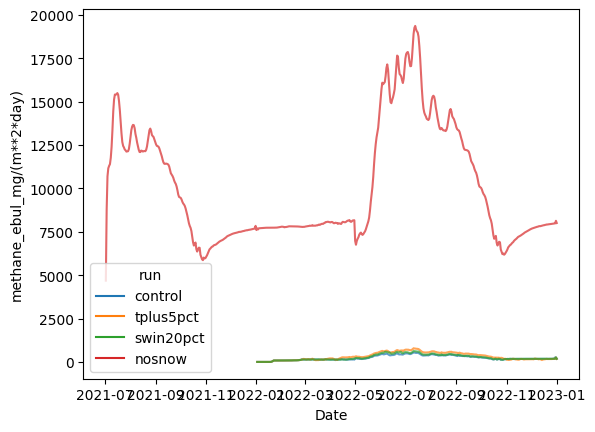

In [19]:
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_ebul_mg/(m**2*day)']!=-999)& (df_methanes['pond']=='unburned')], 
                 x='Date', y='methane_ebul_mg/(m**2*day)', hue='run', alpha=0.7)

<Axes: xlabel='Date', ylabel='methane_ebul_mg/(m**2*day)'>

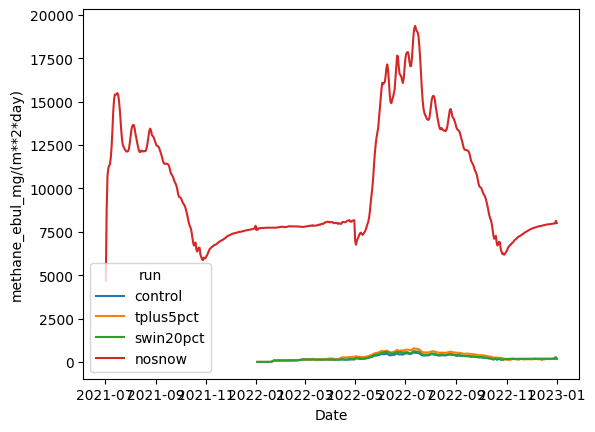

In [20]:
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_ebul_mg/(m**2*day)']!=-999)& (df_methanes['pond']=='unburned')], 
                 x='Date', y='methane_ebul_mg/(m**2*day)', hue='run')

(0.0, 500.0)

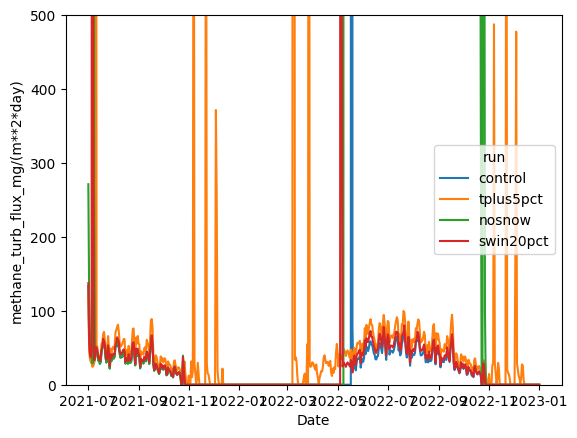

In [21]:
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_turb_flux_mg/(m**2*day)']!=-999)& (df_methanes['pond']=='burned')], 
                 x='Date', y='methane_turb_flux_mg/(m**2*day)', hue='run')
plt.ylim(0,500)

<Axes: xlabel='Date', ylabel='methane_prod_young_mol/(m**2*s)'>

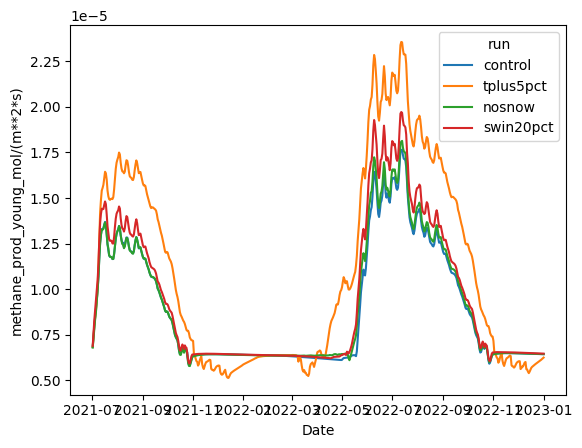

In [22]:
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_prod_young_mol/(m**2*s)']!=-999)& (df_methanes['pond']=='burned')], 
                 x='Date', y='methane_prod_young_mol/(m**2*s)', hue='run')



<Axes: xlabel='Date', ylabel='methane_prod_old_mol/(m**2*s)'>

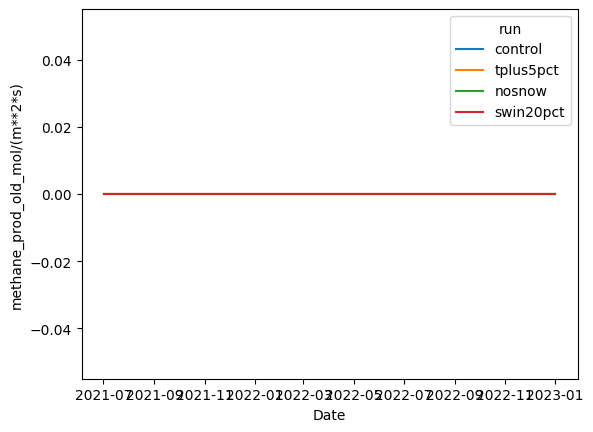

In [23]:
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_prod_old_mol/(m**2*s)']!=-999)& (df_methanes['pond']=='burned')], 
                 x='Date', y='methane_prod_old_mol/(m**2*s)', hue='run')

<Axes: xlabel='Date', ylabel='methane_diffuse_bot_mol/(m**2*s)'>

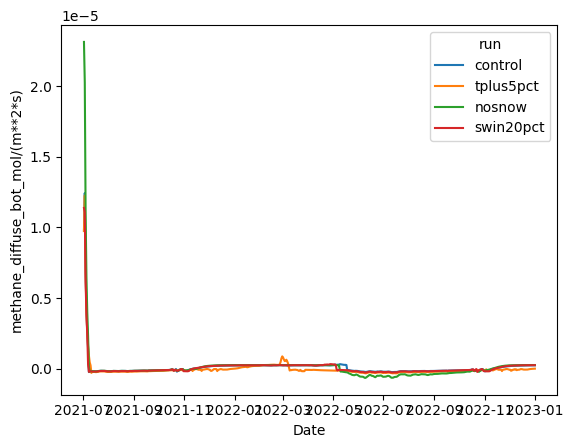

In [24]:
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_diffuse_bot_mol/(m**2*s)']!=-999)& (df_methanes['pond']=='burned')], 
                 x='Date', y='methane_diffuse_bot_mol/(m**2*s)', hue='run')

In [25]:
df_columns_burned = df_methanes.loc[(df_methanes['month']<=10) & (df_methanes['month']>=10)& (df_methanes['pond']=='burned')][['run', 'methane_ebul_sc1',
                                                                           'methane_ebul_sc2', 'methane_ebul_sc3', 'methane_ebul_sc4','methane_ebul_sc5']]
df_columns_burned = df_columns_burned.rename(columns = {'methane_ebul_sc1': 'column 1',
                                         'methane_ebul_sc2': 'column 2', 
                                         'methane_ebul_sc3': 'column 3', 
                                         'methane_ebul_sc4': 'column 4',
                                         'methane_ebul_sc5': 'column 5'})

df_columns_burned = df_columns_burned.groupby(by=['run']).mean().reset_index()
df_columns_burned = pd.melt(df_columns_burned, id_vars=['run'])

<Axes: xlabel='variable', ylabel='value'>

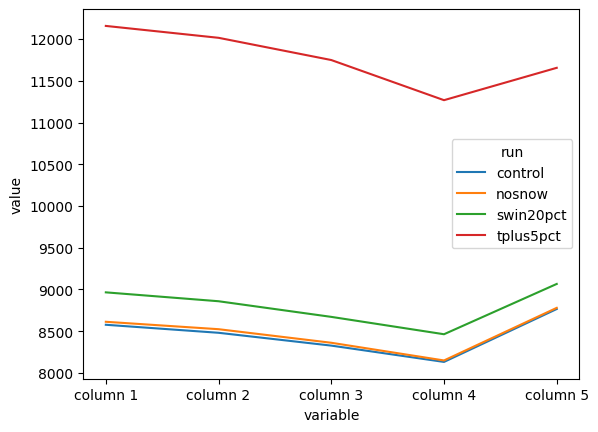

In [26]:
sns.lineplot(data=df_columns_burned, x='variable', y='value', hue='run')